# (29) Gradients -- ```GABAN```

**Motivation**: Full brain (192). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


sys.path.insert(0, os.path.join(git_dir, 'mapalign'))
from mapalign import embed


def compute_grads(
    mice, mode, desc, band,
    use_cos=True, ):
    kws = {
        f"desc_{mode.split('-')[0]}": desc,
        f"band_{mode.split('-')[0]}": band,
    }
    mice.set_kws(**kws)
    a, _ = collect_adjacencies(
        mice=mice,
        mode=mode,
        fill=1.0,
    )
    z = bn.nanmean(np.arctanh(a), 0)
    r = np.nan_to_num(np.tanh(z))
    
    if use_cos:
        norms = np.linalg.norm(r, axis=1, keepdims=True)
        affinity = (r @ r.T) / (norms @ norms.T)
    else:
        affinity = (r + 1) / 2.

    x, emb_dict = embed.compute_diffusion_map(
        affinity, n_components=bs.num_n, return_result=True)
    x = x.T
    return x, emb_dict


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    mice.set_kws(
        desc_ca2='preproc',
        desc_bold='rabies-hp',
    )
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Prep

In [3]:
mice = Mice(192)
bs = Base(mice, mode='bold')
kws_show = show_kws(7)

pal = prepare_palette()
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Compute

In [4]:
grads, emb_dict = compute_grads(
    mice=mice,
    mode='bold',
    desc='rabies-hp',
    band=(0.01, 0.5),
    use_cos=False,
)
lambs = emb_dict['lambdas']
lambs /= lambs.sum()
lamb *= 100

## Plot

In [6]:
grads.shape

(1437, 1438)

In [5]:
x2p = sp_stats.zscore(grads, axis=1)
x2p.shape

(1437, 1438)

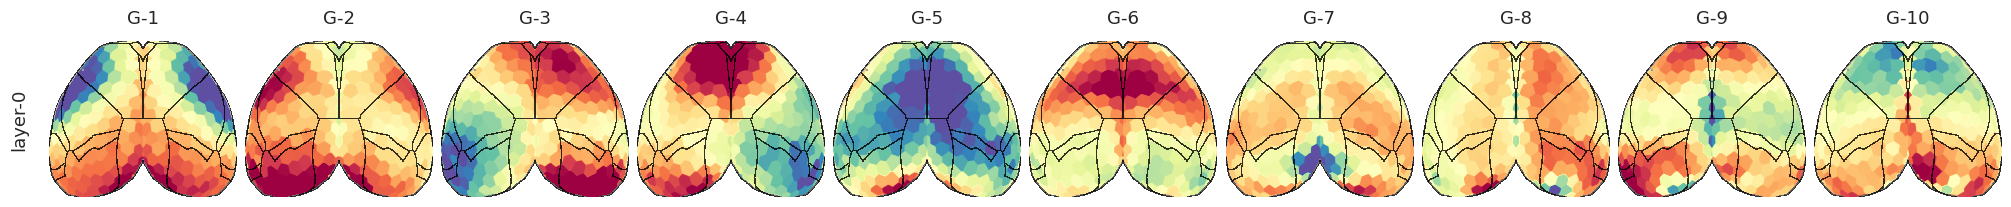

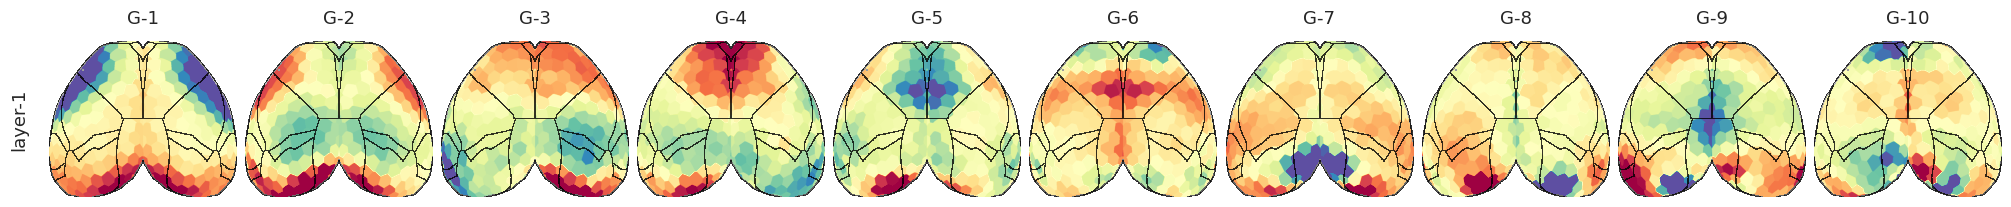

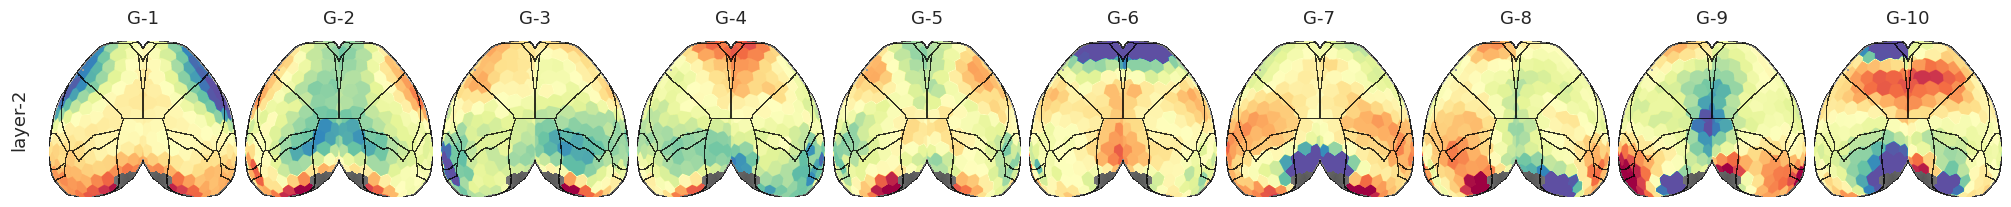

In [13]:
for ll in range(3):
    fig, _ = bs.show(
        data={f"layer-{ll}": x2p[:10]},
        vmin=-2.0, vmax=2.0, figsize=(20, 3),
        titles=[f"G-{i+1}" for i in range(10)],
        cbar=False,
        cmap='Spectral_r',
        contour_cmap='Greys_r',
        layout='constrained',
        layer=ll,
    )

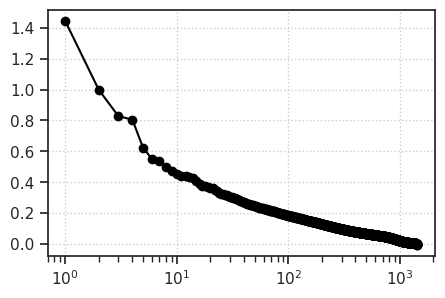

In [28]:
plt.plot(range(1, len(lambs) + 1), lambs, marker='o', color='k')
plt.xscale('log')
plt.grid()
plt.show()